In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=48
CHANNELS=3
EPOCHS=20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\Potato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1500 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

32

(48, 256, 256, 3)
[0 2 1 1 0 0 2 2 0 1 2 0 1 1 2 1 2 1 1 1 1 0 2 2 1 1 1 2 0 1 0 2 2 1 2 1 2
 2 2 0 0 2 2 1 1 1 2 2]


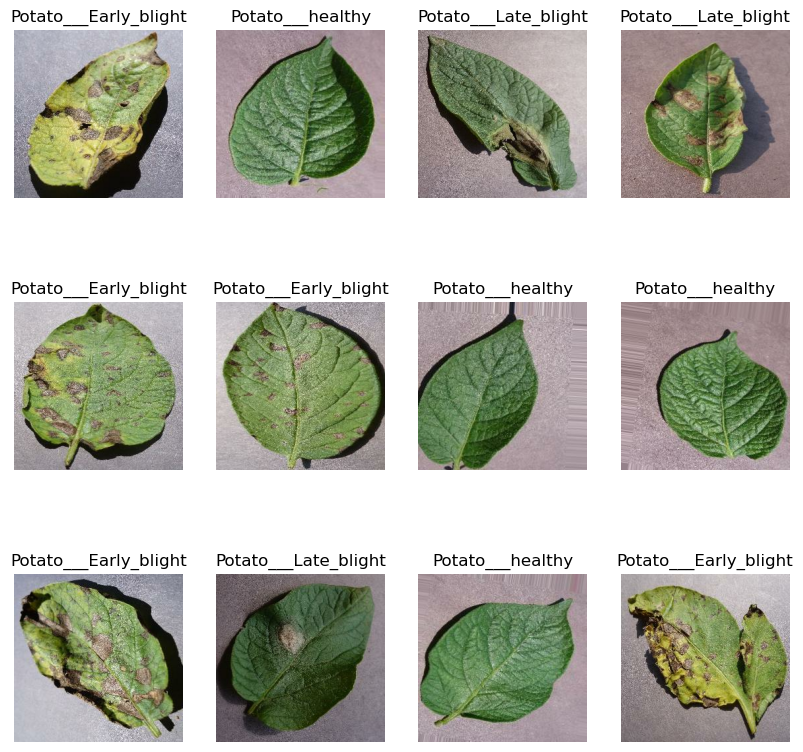

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

25 3 4


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (48, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (48, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (48, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (48, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (48, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (48, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
25/25 [==============================] - 48s 2s/step - loss: 1.0185 - accuracy: 0.4667 - val_loss: 0.8717 - val_accuracy: 0.6181
Epoch 2/20
25/25 [==============================] - 47s 2s/step - loss: 0.5827 - accuracy: 0.7242 - val_loss: 0.4136 - val_accuracy: 0.8264
Epoch 3/20
25/25 [==============================] - 47s 2s/step - loss: 0.4507 - accuracy: 0.8117 - val_loss: 0.4693 - val_accuracy: 0.7431
Epoch 4/20
25/25 [==============================] - 47s 2s/step - loss: 0.3659 - accuracy: 0.8408 - val_loss: 0.2111 - val_accuracy: 0.9097
Epoch 5/20
25/25 [==============================] - 47s 2s/step - loss: 0.2751 - accuracy: 0.8983 - val_loss: 0.2573 - val_accuracy: 0.8819
Epoch 6/20
25/25 [==============================] - 47s 2s/step - loss: 0.2686 - accuracy: 0.9000 - val_loss: 0.2124 - val_accuracy: 0.9097
Epoch 7/20
25/25 [==============================] - 48s 2s/step - loss: 0.3035 - accuracy: 0.8908 - val_loss: 0.3364 - val_accuracy: 0.8819
Epoch 8/20
25/25 [==

In [13]:
scores=model.evaluate(test_ds)
scores

4/4 [==============================] - 2s 316ms/step - loss: 0.1211 - accuracy: 0.9531


[0.12112591415643692, 0.953125]

In [14]:
history.history['loss']

[1.018487811088562,
 0.5826672315597534,
 0.45070114731788635,
 0.3659398853778839,
 0.2751252055168152,
 0.2685808837413788,
 0.3035361170768738,
 0.3140433132648468,
 0.2298581898212433,
 0.19913096725940704,
 0.18296414613723755,
 0.19523687660694122,
 0.14913758635520935,
 0.18967851996421814,
 0.13795460760593414,
 0.1337103545665741,
 0.10089109092950821,
 0.15538939833641052,
 0.18857376277446747,
 0.09360101073980331]

In [15]:
history.history['accuracy']

[0.46666666865348816,
 0.7241666913032532,
 0.8116666674613953,
 0.840833306312561,
 0.8983333110809326,
 0.8999999761581421,
 0.89083331823349,
 0.8791666626930237,
 0.9041666388511658,
 0.9291666746139526,
 0.9258333444595337,
 0.9350000023841858,
 0.9449999928474426,
 0.9266666769981384,
 0.95333331823349,
 0.9424999952316284,
 0.9683333039283752,
 0.9491666555404663,
 0.9350000023841858,
 0.965833306312561]

In [16]:
history.history['val_loss']

[0.8717486262321472,
 0.41355666518211365,
 0.4692608416080475,
 0.21111947298049927,
 0.25729870796203613,
 0.2123871147632599,
 0.3364468216896057,
 0.23819023370742798,
 0.21262475848197937,
 0.20108917355537415,
 0.2619648277759552,
 0.15143604576587677,
 0.23959070444107056,
 0.14021141827106476,
 0.1176799014210701,
 0.08892055600881577,
 0.14623719453811646,
 0.2847473621368408,
 0.08797809481620789,
 0.10060089826583862]

In [17]:
history.history['val_accuracy']

[0.6180555820465088,
 0.8263888955116272,
 0.7430555820465088,
 0.9097222089767456,
 0.8819444179534912,
 0.9097222089767456,
 0.8819444179534912,
 0.8888888955116272,
 0.9375,
 0.9236111044883728,
 0.8958333134651184,
 0.9305555820465088,
 0.9027777910232544,
 0.9305555820465088,
 0.9444444179534912,
 0.9583333134651184,
 0.9444444179534912,
 0.9097222089767456,
 0.9722222089767456,
 0.9652777910232544]

In [18]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

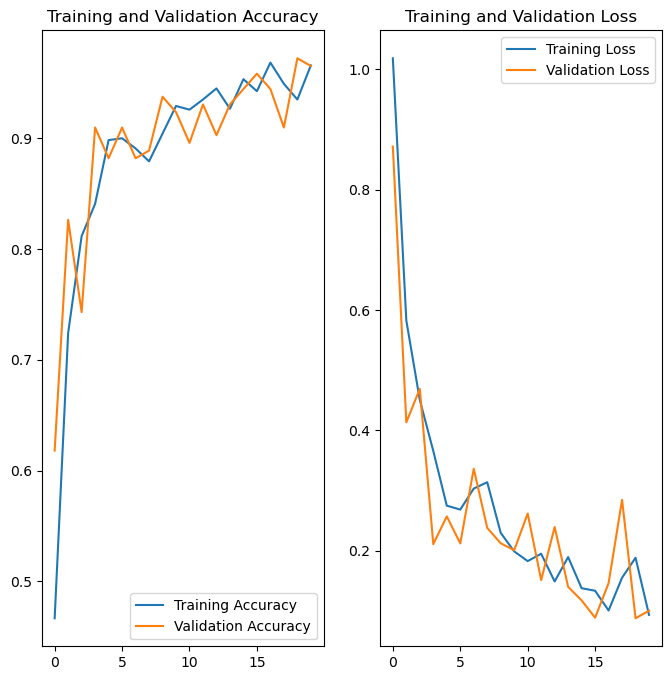

In [19]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [20]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(4):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

2/2 [==============================] - 0s 101ms/step


In [21]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


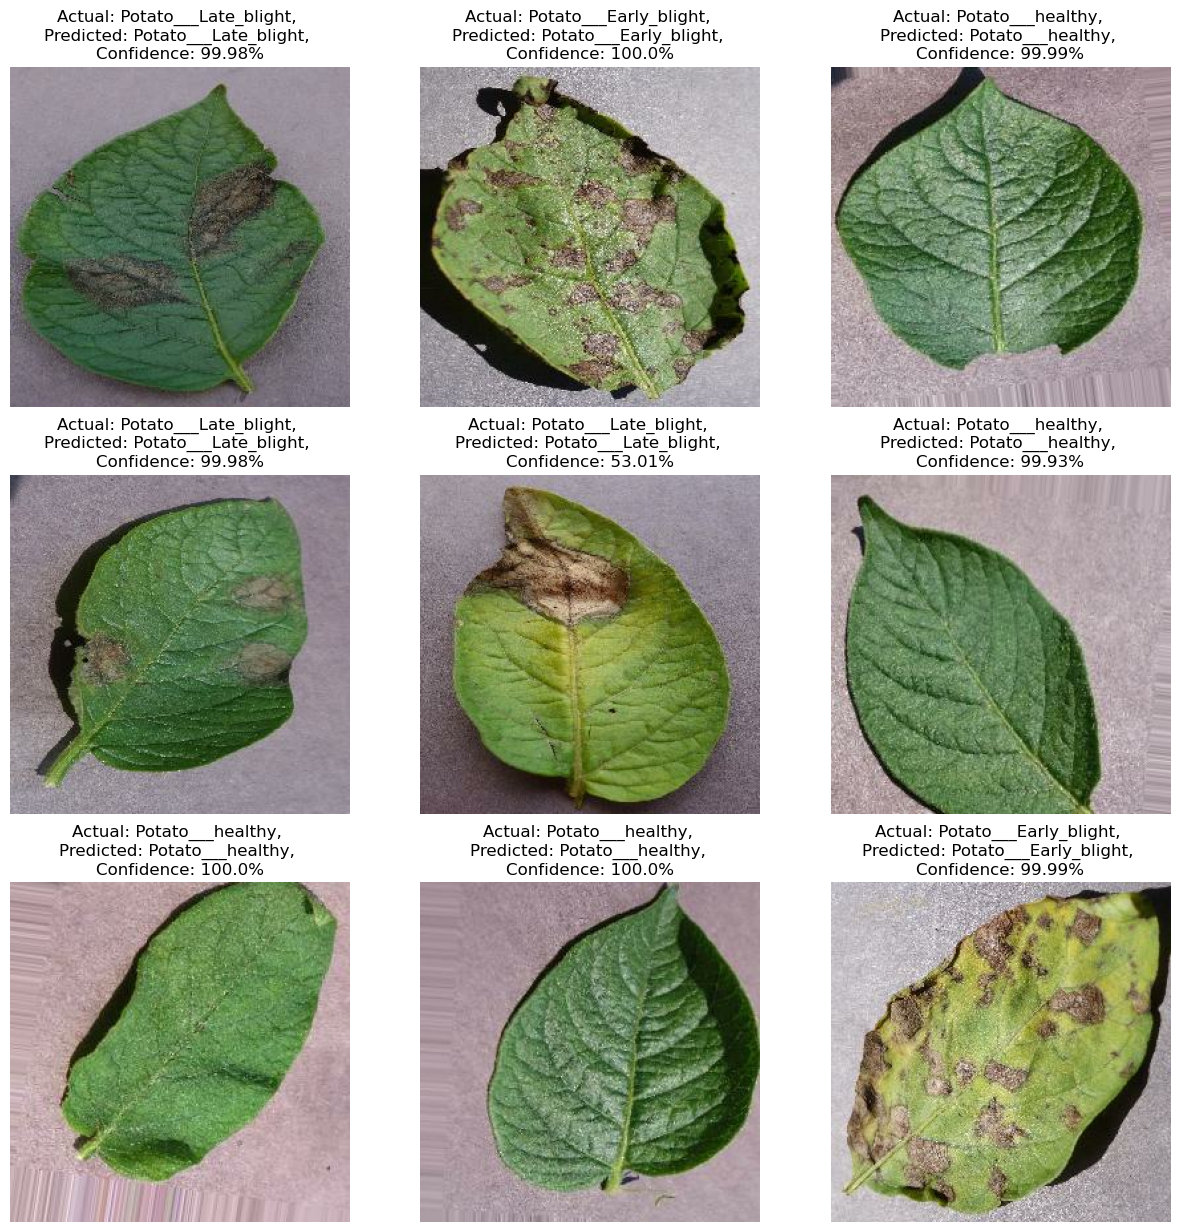

In [22]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [23]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        67
           1       1.00      0.85      0.92        60
           2       0.97      1.00      0.98        65

    accuracy                           0.95       192
   macro avg       0.96      0.95      0.95       192
weighted avg       0.96      0.95      0.95       192



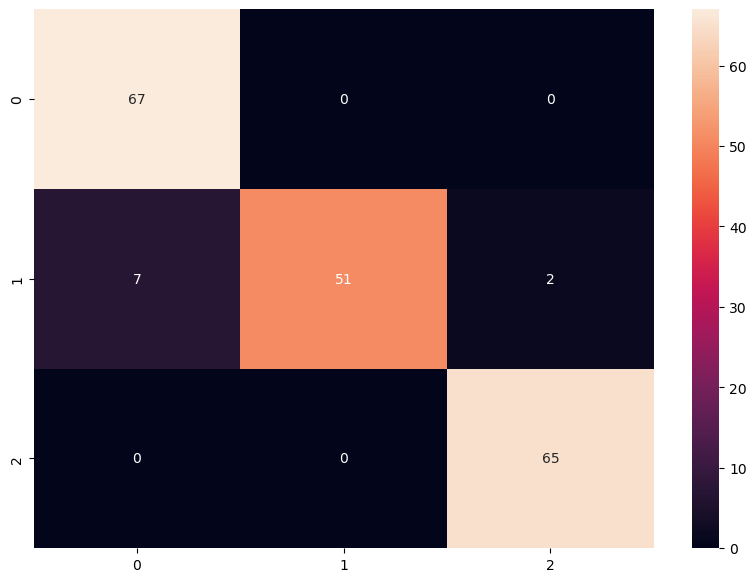

In [24]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [25]:
filename = "Model1-2-BatchSize48.joblib"
joblib.dump(model, filename)

['Model1-2-BatchSize48.joblib']